# Exercise 10 :
# Markovian Langevin Dynamics

* Léa Beaules
* 28 January 2021

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import random
import copy
import numpy as np
import scipy as scy
from tqdm.notebook import trange, tqdm
import time 
from scipy.stats import maxwell

#used for the video
import subprocess
import glob
import os

## Introduction 

We simulate 50 particles in a box (5nmx5nm) with periodic boundary condictions. The particules interact with each other via the lLennard-Jones potential and the velocities and positions are calculated with the Velocity Verlet integrator and van der Waals forces. Because this type of simulations causes the artificial generation of excess heat we add in the simulation the Berendsen thermostat, which keeps the total energy of the system constant instead of artificially increasing. In the last exercice we calculated the autocorrelation function as well as the Stokes friction coefficient.

The specificity of this simulation is that out of the 50 particles, two of them (1st and 50th) are bound to each other in such a way that their distance in constant over time. They will start with an initial velocity = 0, and at each time step we cancel out the contibution of the force along their connecting vector (by appliying a "Constraint force").

We will finally calculate the Free energy of thoses two particles and compare it the their potential energy. And similarly to the last exercice we calculate the constraint force autocorrelation function as well as the Stokes friction coefficient. And compare them to previous results.


## Task I: Implementation of Markovian Langevin dynamics

LE integrator :
$ \vec{v_{k+1}} = \vec{v_{k}} - \frac{1}{m}(\frac{d\vec{U_{k}}}{d\vec{x_{k}}} \Delta t + \vec{v_{k}} \Gamma \Delta t - \sqrt{2\Gamma k_{b}T \Delta t}R_{k}) $

Knowing that for this simulation our potential U is to be equal everywhere, we get : $\frac{d\vec{U_{k}}}{d\vec{x_{k}}} = 0 $, therefor for simplification we won't have this term in our function and we will implement :

$$  \vec{v_{k+1}} = \vec{v_{k}} - \frac{N_{a}}{m}( \vec{v_{k}} \Gamma \Delta t - \sqrt{2*10^{3} \Gamma k_{b}T\Delta t}R_{k}) $$

Constant troughout the simulation :
* $\Delta t$ : time step length
* $\Gamma$ : friction constant
* $k_{b}$ : Bolzmann connstant
* $T$ : Temperature

Changing at each step k :
* $R_{k}$ : is a normally distributed stochastic process
* $v_{k}$ : velocity

In [38]:
def LE_integrator (v_k_vec):
    v_k_x = v_k_vec[0]
    v_k_y = v_k_vec[1]
    
    # Simulating a kick on the particle with random direction
    R_k = np.random.standard_normal(1)
    R_k_angle = np.random.uniform(0,2*np.pi)
    R_kx = np.sin(R_k_angle)*R_k
    R_ky = np.cos(R_k_angle)*R_k
    
    v_k1_x = v_k_x - Na/mass * (v_k_x*Gamma*Dlt_t_s - np.sqrt(2*Gamma*k_b*Temp*Dlt_t_s) * R_kx)
    v_k1_y = v_k_y - Na/mass * (v_k_y*Gamma*Dlt_t_s - np.sqrt(2*Gamma*k_b*Temp*Dlt_t_s) * R_ky)
    
    #print(- Na/mass * (v_k_y*Gamma*Dlt_t_s - np.sqrt(2*Gamma*k_b*Temp*Dlt_t_s) * R_ky))
    
    return [v_k1_x, v_k1_y]

## Task II : LE Simulation

Simulation of 50 particules in a 5x5nm box (with PBC), with 2 having a constant distance between each other.  \
The interparticle interaction is modeled as a Lennard-Jones potential. \
The Velocity Verlet integrator is used to calculate the motion of the particles.
The following constant are used :

In [15]:
box = (5,5)#nm²

#1.000.000 total time steps in the simulation
steps = 100000

#Number of particles in the box
Particule_Nbr = 1
mass = 18 #g/mol

#Time step (2*e-6 in nm)
Dlt_t = 2e-6 #ns = 1fs
Dlt_t_s = 2e-15#in second

#Fricction constant 
Gamma = 2.1e-13 #Kg/s

k_b_mol = 8.314462 #J⋅K^(-1).mol^(-1)
k_b = 1.380649e-23 #J.K-1

Na = 6.02214086e23 #mol-1
Temp = 293.15 #K


time_list_plot = np.linspace(0,steps,steps)

**Position** \
The potential U is assumed to be constant so there is no acceleration on our particle. 

$x_{k+1} = x_{k} + v_{k} \Delta t$ 


In [16]:
def position (x_k, v_k, Dlt_t):
    x_k1 = x_k + v_k*Dlt_t
    return x_k1

**Velocity** \
Here : \
$v_{k+1} = v_{k} + \frac{1}{2}( a_{k} + a_{k+1} ) \Delta t$ \
is not used anymore but the LE integrator is used instead to calculate the velocity

**Kinetic energy**

$E_{kin} = \frac{1}{2} m <v^{2}>$

In [17]:
def Kinetic(Data_traj_list, time_t):
    K_list = []
    for p_ind in range (Particule_Nbr):
        p_vx = Data_traj_list[p_ind][2,time_t]
        p_vy = Data_traj_list[p_ind][3,time_t]
        v = np.sqrt(p_vx**2 + p_vy**2)
        K_list += [v**2]
    K = (1/2)*mass*np.mean(K_list)
    K = K * 10**(-3) #unit convertion into J/mol
    
    return K

**Plot the simulation**

In [18]:
def plot(t):
    for parti in range (Particule_Nbr):
        data_traj = Data_traj_list[parti]
        #Particule = Particules_list[parti]
        c = 'indigo'
        if parti ==0 or parti == 49:
            c = 'cadetblue'

        plt.plot(data_traj[0,t],data_traj[1,t], marker='.', markersize='10',  linestyle = '-', color=c) 

In [19]:
def plot(data_traj):

    x = data_traj[0,:]
    y = data_traj[1,:]
    

    c = 'indigo'
    plt.plot(x,y, marker='.', markersize='3',  linestyle = 'None', color = c)   

    plt.xlabel('position x')
    plt.ylabel('position y')
    plt.xlim(0,5)
    plt.ylim(0,5)

    Titles_graph1 = 'Simulation with ' + str(steps) + 'steps'
    plt.title(Titles_graph1)
    plt.show()

    return (x,y)

**Initialise simulation** 

The particle is placed at a random position in the box, and has an initial velocity coresponding to the thermal velocity for T=293.15 K ( $v_{0} = \sqrt{ \frac{k_{b}T}{m}} = 11.636 m.s^{-1}$) and starts with a random direction.

We store the trajectory and velocity for each step of the siimulation in the array : Data_traj_list. \
First indice :
* 0 : x position in x
* 1 : y position in y
* 2 : vx velocity along x
* 3 : vy velocity along y

Second indice refers to the time step.

In [20]:
print(np.sqrt(k_b_mol * Temp / mass))

11.636591079913014


In [21]:
def Particules_initialise (Particule_Nbr, steps):    
    
    Data_traj_list = np.zeros((4,steps))
    
    #Initial velocities : Thermal velocity with random direction
    vel = np.sqrt(k_b_mol * Temp / mass *10e-3)
    angle = np.random.uniform(0,2*np.pi)
    vx = np.sin(angle)*vel
    vy = np.cos(angle)*vel

    #Ramdom initial position
    x = np.random.uniform(0,box[0])
    y = np.random.uniform(0,box[1])

    Data_traj_list[:,0] = [x, y, vx, vy] #[data type, time step]

    return  Data_traj_list

**Run Simulation**

At the start of the simulation we already have the initial positions and velocities calculated. At each step we calculate : \
* Position at time t+1
* Velocities at time t+1 : with the LE integrator
* Storing both the velocities and position into our array



In [22]:
def RUN ():
    check = []
    check2 = []
    
    for i in trange (0,steps-1,desc= 'Run the simulation'): 
        
        Data_t = Data_traj_list[:,i]
        
        #calculat⋅ing the position and implementing the periodic boundary conditions
        x_1 = position (Data_t[0], Data_t[2], Dlt_t)%box[0]
        y_1 = position (Data_t[1], Data_t[3], Dlt_t)%box[1]
        
        v1_vec = LE_integrator([Data_t[2], Data_t[3]])
        
        # adding the particule position and velocity into the array
        Data_traj_list[0,i+1] = x_1
        Data_traj_list[1,i+1] = y_1     
        Data_traj_list[2,i+1] = v1_vec[0]
        Data_traj_list[3,i+1] = v1_vec[1]
  
        check += [ v1_vec[0] ]
        check2 += [v1_vec[1]]
    return Data_traj_list, check, check2

In [39]:
Data_traj_list = Particules_initialise (Particule_Nbr, steps)
Data_traj_list, check, check2 = RUN()

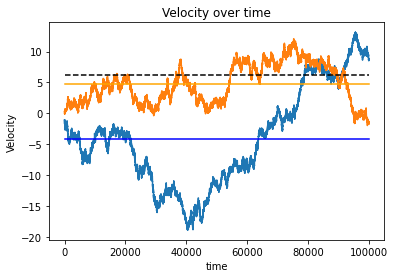

In [40]:
plt.plot(time_list_plot[0:-1], check)
plt.plot(time_list_plot[0:-1], check2, alpha = 1)
plt.plot([time_list_plot[0],time_list_plot[-1]], [np.mean(check), np.mean(check)], color ='blue')
plt.plot([time_list_plot[0],time_list_plot[-1]], [np.mean(check2), np.mean(check2)], color ='Orange')
total_mean = np.sqrt(np.mean(check)**2+np.mean(check2)**2)
plt.plot([time_list_plot[0],time_list_plot[-1]], [total_mean, total_mean], linestyle='--', color ='Black')

plt.xlabel('time')
plt.ylabel('Velocity')

plt.title('Velocity over time')
plt.show()

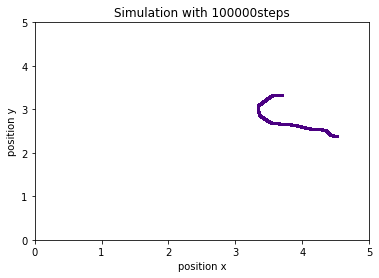

In [41]:
x, y =plot(Data_traj_list)

### Video

In [ ]:
def creat_files():
    os.chdir("Image_storing_video")

    #def plot_simulation (Particule_Nbr, Data_traj_list, Particules_list):
    for t in trange (steps) :
        for parti in range (Particule_Nbr):
            data_traj = Data_traj_list[parti]
           
            c = 'indigo'
            if parti ==0 or parti == 49:
                c = 'cadetblue'
            plt.plot(data_traj[0,t],data_traj[1,t], marker='.', markersize='10',  linestyle = '-', color = c)

            plt.xlabel('position x')
            plt.ylabel('position y')
            plt.xlim(0,box[0])
            plt.ylim(0,box[1])
        plt.savefig("File%02d.png" % t)
        #plt.show()
        #plt.savefig("file.png")
        plt.close()



    Titles_graph1 = 'Example of one of the simulation of ' + str(Particule_Nbr)+ ' particules, with' + str(steps) + 'steps'
    plt.title(Titles_graph1)
    os.chdir("../")

In [ ]:
def creat_video():
    os.chdir("Image_storing_video")
    
    subprocess.call(['ffmpeg', '-framerate', '5', '-i', 'File%02d.png', '-r', '30', '-pix_fmt', 'yuv420p', 'Contagion08.mp4'])
    #subprocess.call(['ffmpeg', '-framerate', '8', '-i', Titles_files, '-r', '30', '-pix_fmt', 'yuv420p', Filename])

    
    for file_name in glob.glob("*.png"):
        os.remove(file_name)

    os.chdir("../")

In [ ]:
'''
retval = os.getcwd()
print ("Current working directory %s" % retval)
creat_files()
creat_video()
'''

## Task III: Determination of diffusion coefficient

**Diffusion coefficient :**
$$ D = \frac{\Delta \vec{x}(t)^{2} }{4t} $$

with $ \Delta \vec{x}(t) ^2 = (\vec{x}(t) − \vec{x}(t_{0}) )^2 = \Delta x_{x}(t)^2 + \Delta x_{y}(t)^2$

In [58]:
def Diff_coef_old(t):
    D_x = (Data_traj_list[0,t] - Data_traj_list[0,0])**2 / 4*t
    D_y = (Data_traj_list[1,t] - Data_traj_list[1,0])**2 / 4*t
    return [D_x,D_y]

In [66]:
def Diff_coef(t):
    Dlt_x = Data_traj_list[0,t] - Data_traj_list[0,0]
    Dlt_y = Data_traj_list[1,t] - Data_traj_list[1,0]
    D = (Dlt_x**2 + Dlt_y**2)/(4*t)
    Dltx = (Dlt_x**2 + Dlt_y**2)
    return D, Dltx

**Fricction coefficient**
$$ \Gamma = \frac{k_{b} T}{D}$$

In [45]:
def Fric_coef(D):
    Gamma = k_b * Temp / D
    return Gamma

**Calculation of D and $\Delta x^{2}$**

In [141]:
D_list = []
Dltx_list = []
Gamma_list = []

for t in trange(1,steps-1):
    D, Dltx = Diff_coef(t)
    D_list += [D]
    Dltx_list += [Dltx]
    Gamma_list += [Fric_coef(D)]

**Analysis of the evolution of $\Delta x^{2}$**

We can clearly see that for small values of t ( $<62000$ ),  $\Delta x^{2}$ is propotional to $t^{2}$. And after that the particle follows a diffusive behavior, therefore it should evolve linearly with t. 

In [137]:
t_sqrd = []
for t in time_list_plot:
    t_sqrd += [t**2 * 1.75/60000**2 - 0.2]

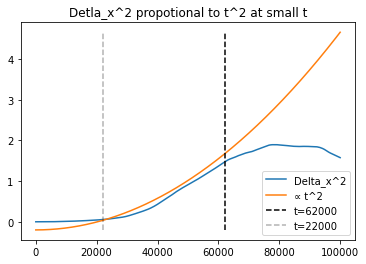

In [138]:
plt.plot(time_list_plot[1:-1], Dltx_list, label ='Delta_x^2')
plt.plot(time_list_plot[:-1], t_sqrd[:-1], label = '∝ t^2')
plt.plot([62000,62000], [t_sqrd[0],t_sqrd[-1]],linestyle='--', color='Black', label='t=62000')
plt.plot([22000,22000], [t_sqrd[0],t_sqrd[-1]],linestyle='--', color='Black', alpha = 0.3, label='t=22000')
plt.legend()
a=plt.title('Detla_x^2 propotional to t^2 at small t')

**Analysis of D**

We can see that beween 22000 and 62000 the evolution of D follows a linear evolution in function of t, which is consistant with an evolution proportionalto $t^{2}$ for $\Delta x^{2}$.

* Linear fit of t : $ \frac{(t-22000)}{60000} 10^{-6}$

In [132]:
t_lin = []
for t in time_list_plot:
    t_lin += [(t-22000) * 10e-6/60000 ]

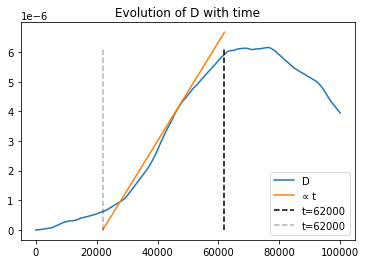

In [140]:
plt.plot(time_list_plot[1:-1], D_list, label ='D')
plt.plot(time_list_plot[22000:62000], t_lin[22000:62000], label = '∝ t')
plt.plot([62000,62000], [min(D_list),max(D_list)],linestyle='--', color='Black', label='t=62000')
plt.plot([22000,22000], [min(D_list),max(D_list)],linestyle='--', color='Black', alpha=0.3, label='t=62000')
plt.legend()
a=plt.title('Evolution of D with time')

**Analysis of the evolution of $\Gamma$**

$\Gamma $ is propotional to the inverse of D.

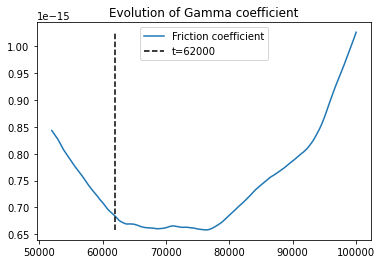

In [174]:
plt.plot(time_list_plot[52001:-1], Gamma_list[52000:], label='Friction coefficient')
plt.plot([62000,62000], [min(Gamma_list[52000:]),max(Gamma_list[52000:])],linestyle='--', color='Black', label='t=62000')
#plt.plot([time_list_plot[52001],time_list_plot[-1]], [2.1e-13,2.1e-13])
plt.legend()
a=plt.title('Evolution of Gamma coefficient')

**Interpretation of the results**

**Similarities between the two curves**
* $R_{i}$ < 0.4 \
For values of $R_{i}$ smaller then the 'equilibrium distance', corresponding to the minimum of the Lennard Jones potential curve : $R_{equ} = 0.435nm$ our particle are constraint to a distance at which they are repulsing eachother away. According to the Lennard Jones potential tocloser they are the stronger the repulsive force is, therefore we get a strong constraint force for small values of $R_{i}$.

* $R_{i}$ ~ 0.4 \
When the constaint disance is close to the 'equilibrium distance', the constaint force is also at it's minimum.

* $R_{i}$ > 0.4 \
The further away the particles are from each other, the weaker the interactionbetween each other gets. But because our simulation bow is full of other particles they have a higher probability to be close to the other particles. Which means the contraint foce increase.

**Differences** 
* Because we are not calculating the force only bewteen the two constraint particles, but also with the surounding ones, the constraint force has usually larger values then the Lennard Jones potential.
* The The constraint force is less 'smoth' because we are calculating from a reduced sample of values for $R_{i}$. And also because the the initial parameters of each simulations can differ as they are chosen randomly, for example the 50th particle can be placed very close to another particle at t=0 which will lead to an overall larger constraint force.

There may be a problem of order of magnitude, as I tried to convert both energies into J/mol but my Free energy (and my constraint force) seem to have too hight powers of 10. Thismay cause wrong order of magnitude for the following calculations as well, paticularly for the coefficient of friction.
